# Assignment 3

## Group members
- Axel Gustafsson - gusgusaxa@student.gu.se
- Erdem Halil - gushaliler@student.gu.se

#### 1. Implement the K-means algorithm

In [1]:
import os 
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
def kmeans(x, K, n_init):
    # Randomly initialize centroids
    centroids = x[np.random.choice(x.shape[0], K, replace=False)]

    for _ in range(n_init):
        # Assign labels to each data point based on distance to centroids
        distances = np.sqrt(((x - centroids[:, np.newaxis])**2).sum(axis=2))
        labels = np.argmin(distances, axis=0)

        # Update centroids
        new_centroids = np.array([x[labels == k].mean(axis=0) for k in range(K)])

        # Check for convergence
        if np.all(new_centroids == centroids):
            break
        
        centroids = new_centroids

    return centroids, labels

**If you run this algorithm multiple times, do you get the same result every time? If so, why; if not, how do you determine which result is the best one? How do you choose what K value to use?**

We will not get the same result when we run the algorithm multiple times since the initialization of clusters is random. This may affect the result, but we found that for our dataset the result is very similar from one run to the next. 

By plotting the SSE for different values of K and we can see where the plot flattens out and we pick the k where that happens. Lower SSE suggest tighter clusters, as SSE measures the sum of squared distances between each data point and its assigned centroid within a cluster. We want to minimize the SSE, but instead of picking the absoulutely lowest value, we pick a K where the decrease of SSE slows down, as the improvement after that becomes marginal. In our case the decrease of SSE slows down after K = 3 (see below), so that is our optimal value for K. This is something that we expected since we know that the iris dataset features 3 labels and this likely means that each label will be correctly grouped in a cluster.

By observing the silhouette score for different k we can find which k corresponds to the highest silhouette score, as the higher the score, the better clustering. In our case, the highest value for the silhouette score is at K = 3.

**Implement both SSE and the Silhouette score; use them to address these questions.**


In [3]:
def sse(x, centroids, labels):
    sse = 0
    for k in range(len(centroids)):
        sse += np.sum((x[labels == k] - centroids[k])**2)
    return sse

In [4]:
# Calculate silhouette score
def silhouette_score(x, labels):
    n = len(x)
    silhouette_vals = []

    for i in range(n):
        # Calculate average distance of point i to other points in the same cluster
        cluster_idx = labels[i]
        cluster_points = x[labels == cluster_idx]
        a_i = np.mean(np.linalg.norm(x[i] - cluster_points, axis=1))

        # Calculate average distance of point i to points in neighboring clusters
        b_i = np.min([np.mean(np.linalg.norm(x[i] - x[labels == j], axis=1)) 
                      for j in range(len(np.unique(labels))) if j != cluster_idx])

        # Calculate silhouette score for point i
        silhouette_i = (b_i - a_i) / max(a_i, b_i)
        silhouette_vals.append(silhouette_i)

    # Calculate overall silhouette score
    silhouette_score = np.mean(silhouette_vals)
    return silhouette_score

In [5]:
def elbow_method(x, K_max, n_init):
    sse_vals = []
    # Calculate SSE for each K
    for K in range(1, K_max+1):
        # Run k-means algorithm for K
        centroids, labels = kmeans(x, K, n_init)
        # Calculate SSE for K and append to list
        sse_vals.append(sse(x, centroids, labels))
    return sse_vals

In [6]:
from sklearn.datasets import load_iris
iris = load_iris()
X = iris.data

# Run k-means clustering for iris dataset with K=3
centroids, labels = kmeans(X, 3, 1000)

# Calculate sum of squared errors
print("SSE:", sse(X, centroids, labels))

# Calculate silhouette score
print("Silhouette score:", silhouette_score(X, labels))

SSE: 78.85144142614601
Silhouette score: 0.5617085758870528


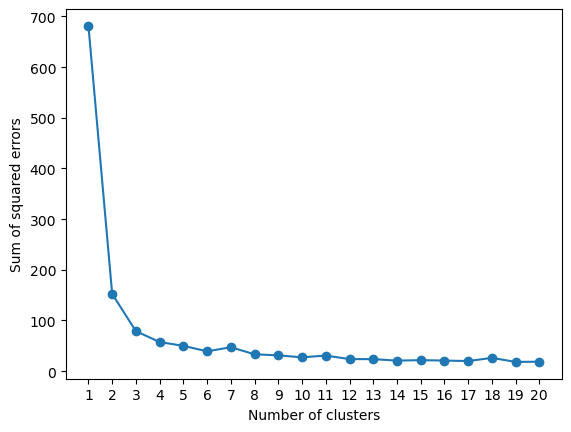

In [7]:
# Run elbow method
max_K = 20
sse_vals = elbow_method(X, max_K, 1000)

# Plot elbow method
plt.plot(range(1, max_K+1), sse_vals, marker='o')
plt.xlabel("Number of clusters")
plt.xticks(range(1, max_K+1))
plt.ylabel("Sum of squared errors")
plt.show()

**Discuss the similarities and differences between 1) K-means, 2) Gaussian Mixture Models (GMM) and 3) the Gaussian naive Bayes classifier in terms of their assumptions and parameter estimation methods.**

An assumption of K-means is that the clusters are spherical and that means that it might not be able to cluster data correctly, if the data is best clustered with clusters of non-spherical shapes. GMM does a better job with clusters with different shapes as they can be elliptical. Another assumption of K-means is that it uses hard assignment. This means that each data point is assigned to exactly one cluster, the one with the closes centroid. This is different from GMM which uses soft clustering, meaning that each data point has a probability of belonging to multiple clusters. This also allows for more complex analysis like overlapping clusters.

An assumption of GMM is that the data comes from a mixture of multiple Gaussian distributions, where each represent a different cluster. This makes it possible to correctly classify different clusters. But if the data does not come from Gaussian distributions, then the clustering might not be correct.

The parameters of GMM are estimated by maximizing the likelihood and this is done by applying the EM-algorithm. K-means uses the same steps as in the EM-algorithm, as it iteratively alternates between assigning data points to clusters and updating the cluster centroids. A difference is that when assigning data points to clusters K-means gives 0 probability to all clusters except one which gets a probability of 1. This is because of the assumption of hard assignment. GMM gives a non-zero probability to every cluster.

Both GMM and Gaussian Naive Bayes assume Gaussian distributions, but where GMM assumes this for the entire dataset GNB assumes this for features within a class. GNB assumes feature independence within each class, which may be an oversimplification depending on the dataset. GMM and K-means do not assume independence and they can model clusters that have features which are not independent.


#### 2. Apply the K-means algorithm to compress images

In [8]:
def load_image(image_path):
    # Open the image using PIL
    img = Image.open(image_path)

    # Convert the image to a numpy array
    img_array = np.array(img)

    # Get image dimensions
    height, width, channels = img_array.shape

    # Reshape the image array to 2D to make it compatible with K-means input
    # Return height and width to reshape the image back to original dimensions later on
    return img_array.reshape((height * width, channels)), height, width

In [9]:
def reconstruct_image(labels, centroids, height, width):
    # Reshape the labels to match the original image shape
    labels_reshaped = labels.reshape((height, width))

    # Create an empty array for the reconstructed image
    reconstructed_image = np.zeros((height, width, len(centroids[0])), dtype=np.uint8)

    # Fill in the pixel values with the centroid values based on the labels
    for i in range(height):
        for j in range(width):
            reconstructed_image[i, j] = centroids[labels_reshaped[i, j]]

    # Convert the array to an image
    reconstructed_image = Image.fromarray(reconstructed_image)

    return reconstructed_image

In [10]:
def compress_image(image, K, n_init=10):
    # Load the image
    img, h, w = load_image(image)

    # Run k-means on the image
    centroids, labels = kmeans(img, K, n_init)

    # Get the compressed image
    compressed_img = reconstruct_image(labels, centroids, h, w)
    return compressed_img

In [11]:
def plot_image(original, compressed, K):
    # Plot the compressed and original image side-by-side
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(original)
    ax[0].set_title('Original Image')
    ax[0].axis('off')

    ax[1].imshow(compressed)
    ax[1].set_title(f'Compressed Image, K={K}')
    ax[1].axis('off')
    
    plt.tight_layout()
    plt.show()

In [12]:
def get_size_ratio(original, compressed):
    # Get the file size of the original and compressed image
    original_size = os.path.getsize(original)
    compressed_size = os.path.getsize(compressed)

    # Calculate the ratio of the file sizes and return it
    return compressed_size / original_size

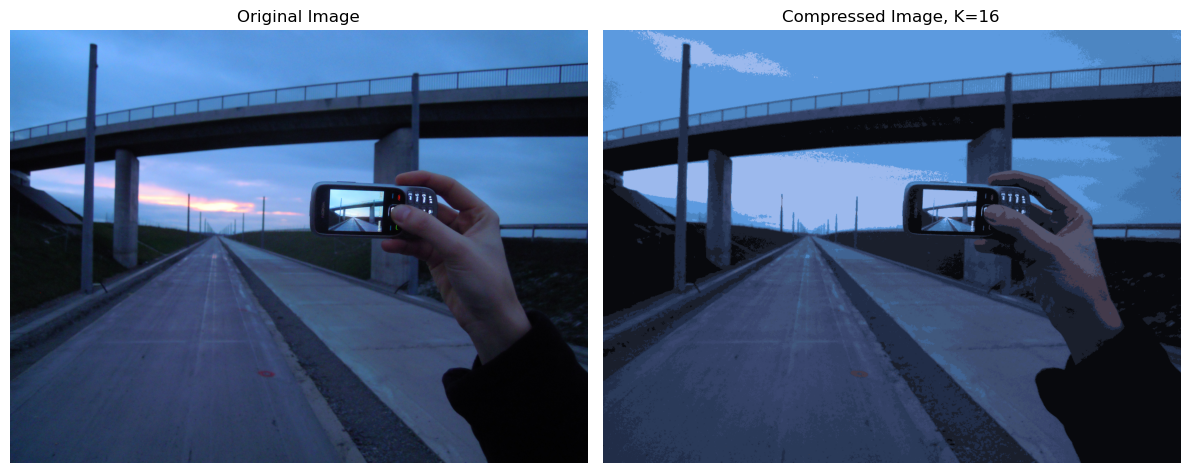

Compression ratio: 0.141


In [13]:
K = 16 # Number of clusters
img, cmp = 'images/1.png', 'compressed/1.png'

compressed_img = compress_image(img, K)
plot_image(Image.open(img), compressed_img, K)
compressed_img.save(cmp)
print(f"Compression ratio: {get_size_ratio(img, cmp):.3f}")

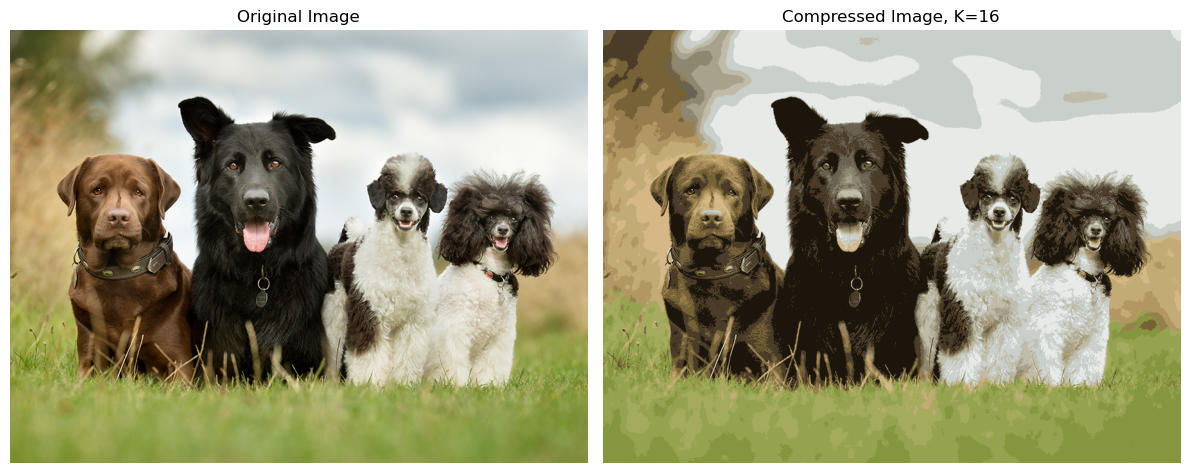

Compression ratio: 0.167


In [14]:
img, cmp = 'images/2.png', 'compressed/2.png'

compressed_img = compress_image(img, K)
plot_image(Image.open(img), compressed_img, K)
compressed_img.save(cmp)
print(f"Compression ratio: {get_size_ratio(img, cmp):.3f}")

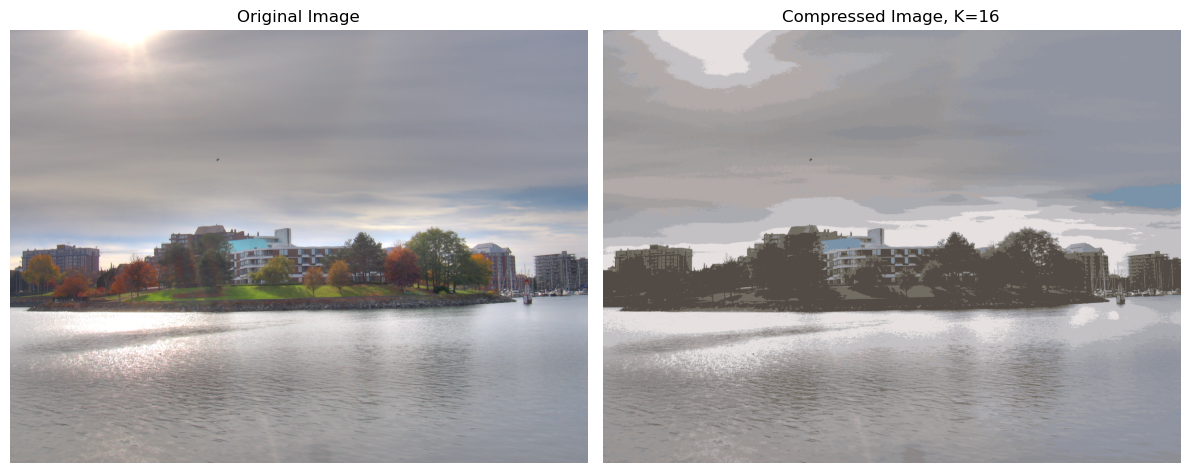

Compression ratio: 0.178


In [15]:
img, cmp = 'images/3.png', 'compressed/3.png'

compressed_img = compress_image(img, K)
plot_image(Image.open(img), compressed_img, K)
compressed_img.save(cmp)
print(f"Compression ratio: {get_size_ratio(img, cmp):.3f}")

The lower K is, the more compressed the image becomes. We can observe that the value of K determine how many colours are used in the compressed image. In the extreme case where K = 1, the compressed image is simply one solid colour. We chose K = 16 and here the compressed image has 16 different colours and it closely resembles the original image. 

The compression ratio for K = 16 is about 0.180 for an image of size 4 194 587 bytes. When we save the compressed image its size is 751 370 bytes, and the compression ratio is thus 751370 / 4194587 = 0.178. This matches our estimation and it is not surprising.

#### 3. Use AIC and BIC to choose K for Gaussian Mixture Models

In [16]:
from sklearn.mixture import GaussianMixture
from sklearn.datasets import load_breast_cancer

data = load_breast_cancer().data

In [17]:
def aic_gmm(x, gmm):
    n, d = x.shape  # Number of data points and dimensions
    k = gmm.n_components # Number of clusters

    # Calculate AIC for the GMM
    ###### Complexity of the model:
    #           - Priors: k - 1
    #           - Means: k * d
    #           - Covariance matrices: k * d * (d + 1) / 2
    ###### Log likelihood of the data (error):
    #           - -1 * gmm.score(x) * n
    # Lastly, multiply by 2 to get the AIC

    priors = k - 1
    means = k * d
    covariances = k * d * (d + 1) / 2
    error = -1 * gmm.score(x) * n

    return 2 * (priors + means + covariances + error)

In [18]:
def bic_gmm(x, gmm):
    n, d = x.shape  # Number of data points and dimensions
    k = gmm.n_components # Number of clusters

    # Calculate BIC for the GMM
    ###### Complexity of the model:
    #           - Priors: k - 1
    #           - Means: k * d
    #           - Covariance matrices: k * d * (d + 1) / 2
    #           - Complexity penalty: 1/2 * log(n)
    ###### Log likelihood of the data (error):
    #           - -1 * gmm.score(x) * n
    # Lastly, multiply by 2 to get the BIC

    priors = k - 1
    means = k * d
    covariances = k * d * (d + 1) / 2
    complexity_penalty = 1/2 * np.log(n)
    error = -1 * gmm.score(x) * n
    
    return 2 * ((priors + means + covariances) * complexity_penalty + error)


In [19]:
import warnings
warnings.filterwarnings('ignore') # Ignore warnings for KMeans in GMM

def choose_best_k(data, K_max=15):
    best_aic, best_bic = float('inf'), float('inf')
    best_k_aic, best_k_bic = 0, 0
    aic_l, bic_l = [], []

    for k in range(1, K_max + 1):  # Trying different values of K from 1 to K_max
        # Fit a Gaussian mixture with EM
        gmm = GaussianMixture(n_components=k, random_state=0).fit(data)

        # Calculate AIC and BIC
        aic = aic_gmm(data, gmm)
        aic_l.append(aic)
        
        bic = bic_gmm(data, gmm)
        bic_l.append(bic)

        # Save the best (lowest) AIC and BIC
        if aic < best_aic:
            best_aic = aic
            best_k_aic = k
        
        if bic < best_bic:
            best_bic = bic
            best_k_bic = k
    
    return best_k_aic, best_k_bic, aic_l, bic_l


Best K based on AIC: 7
Best K based on BIC: 2


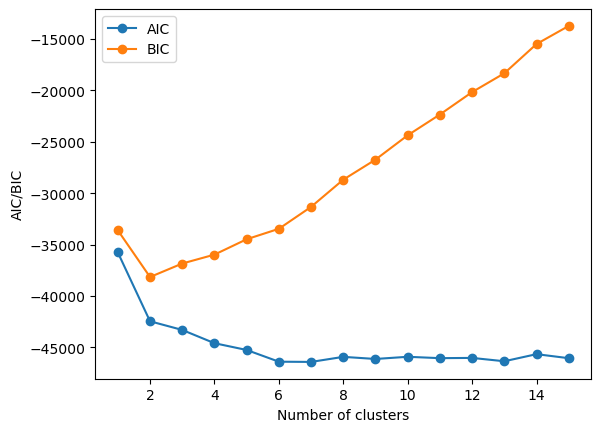

In [20]:
K_max = 15
best_k_aic, best_k_bic, aic_l, bic_l = choose_best_k(data, K_max)
print(f"Best K based on AIC: {best_k_aic}")
print(f"Best K based on BIC: {best_k_bic}")

# Plot AIC and BIC
plt.plot(range(1, K_max + 1), aic_l, marker='o', label='AIC')
plt.plot(range(1, K_max + 1), bic_l, marker='o', label='BIC')
plt.xlabel('Number of clusters')
plt.ylabel('AIC/BIC')
plt.legend()
plt.show()

**Choose the best K on the breast_cancer data set using AIC and BIC and discuss your observations.**

From the graph and the best K results we get from the function, we can say that the optimal K for the breast cancer dataset appears to be K = 2. Even though the best K based on AIC is 7, we need to consider that adding 5 more clusters adds unnecessary complexity which is heavily penalized in BIC. The results from the criterion show that a simpler model is just sufficient. 